In [1]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import notebook
from sklearn.preprocessing import StandardScaler
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model

#### Input params ##################
stk_path = "./data/etf_1698.csv"
test_size = 0.2                # テストデータサイズ
cv_size = 0.2                  # バリデーションデータサイズ

N = 4                          # 特徴量として使用する直前の日

#LSTM パラメータ。初期値
lstm_units=50
dropout_prob=1
optimizer='adam'
epochs=1
batch_size=1

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# seed値を設定
seed(101)
set_random_seed(model_seed)

Using TensorFlow backend.


In [2]:
def get_mape(y_true, y_pred): 
    """
    平均絶対パーセント誤差 (MAP Error) を求める
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def get_x_y(data, N, offset):
    """
    データをx (features) と y (target)に分割
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y


def get_x_scaled_y(data, N, offset):
    """
    dataをx(features)とy（target）に分割
    xを平均1、分散1に標準化する
    yは標準化しない
    Inputs
        data     : 使用するデータ
        N
        offset
    Outputs
        x_scaled : 特徴量：平均1、分散1に標準化する
        y        : target　value：標準化しない
        mu_list  : 平均値のリスト
        std_list : 分散のリスト
    """
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        std_list.append(np.std(data[i-N:i]))
        x_scaled.append((data[i-N:i]-mu_list[i-offset])/std_list[i-offset])
        y.append(data[i])
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list


def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_cv_scaled, \
                          y_cv, \
                          mu_cv_list, \
                          std_cv_list, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1):
    '''
    LSTMを用いてモデルを訓練、予測、評価する
    Inputs
        x_train_scaled  : ここでは前の９個の値を用いて次の値を求める
        y_train_scaled
        x_cv_scaled     : この値を用いて予測する
        y_cv            : 真の予測値
        mu_cv_list      :平均値のリスト
        std_cv_list     :分散値のリスト
        
        #lstmのパラメータ
        lstm_units
        dropout_prob
        optimizer
        epochs
        batch_size
    Outputs
        rmse            : 平均平方二乗誤差　RMS Error
        mape            : 平均絶対パーセント誤差 MAP Error
        est             : 予測値
    '''
    # LSTM　ネットワークを作成
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1))

    # 訓練
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # 予測
    est_scaled = model.predict(x_cv_scaled)
    est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
    
    # RMSE と MAPE　を求める
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est

# データ読み込み

In [3]:
df = pd.read_csv(stk_path, sep = ",")

# Dete列をdate型に変換
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# headを小文字に変換
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# month列を追加
df['month'] = df['date'].dt.month

# datetimeでソート
df.sort_values(by='date', inplace=True, ascending=True)


df.head()

,date,open,high,low,close,volume,trading_value,month
0,2015-01-05,1529,1529,1486,1498,9510,1498,1
1,2015-01-06,1451,1465,1451,1452,11550,1452,1
2,2015-01-07,1450,1460,1447,1450,4720,1450,1
3,2015-01-08,1469,1477,1468,1471,1330,1471,1
4,2015-01-09,1480,1481,1468,1472,2050,1472,1


Text(0, 0.5, 'JPY')

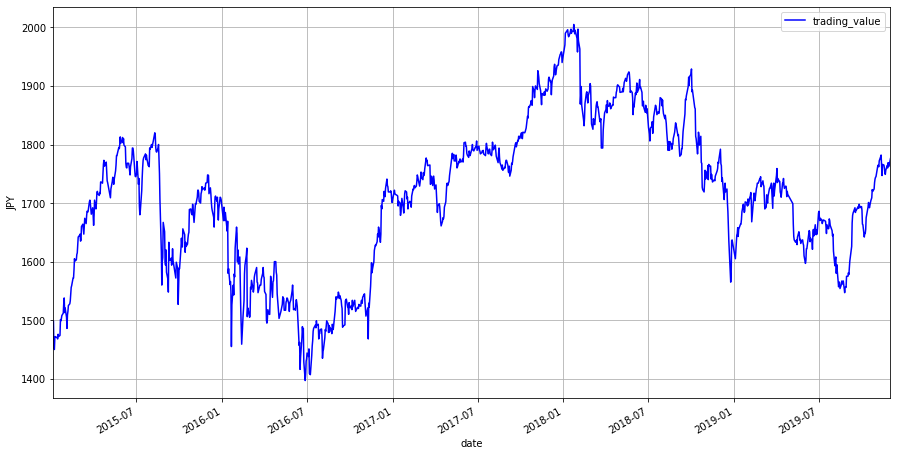

In [4]:
# trading_valueをプロット
rcParams['figure.figsize'] = 15, 8

ax = df.plot(x='date', y='trading_value', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("JPY")

# データをtrain,cv,testに分割 

In [5]:
# データセットのサイズを取得
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))


# train, cv, testに分割
train = df[:num_train][['date', 'trading_value']]
cv = df[num_train:num_train+num_cv][['date', 'trading_value']]
train_cv = df[:num_train+num_cv][['date', 'trading_value']]
test = df[num_train+num_cv:][['date', 'trading_value']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 720
num_cv = 239
num_test = 239
train.shape = (720, 2)
cv.shape = (239, 2)
train_cv.shape = (959, 2)
test.shape = (239, 2)


In [6]:
# データセットを標準化
scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train['trading_value']).reshape(-1,1))
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))

# x_trainとy_trainに分割
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)
print("x_train_scaled.shape = " + str(x_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))

scaler.mean_ = [1667.54166667]
scaler.var_ = [14943.72604167]
x_train_scaled.shape = (716, 4, 1)
y_train_scaled.shape = (716, 1)


In [7]:
# バリデーションデータセットを標準化
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['trading_value']).reshape(-1,1), N, num_train)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("len(mu_cv_list) = " + str(len(mu_cv_list)))
print("len(std_cv_list) = " + str(len(std_cv_list)))

x_cv_scaled.shape = (239, 4, 1)
y_cv.shape = (239, 1)
len(mu_cv_list) = 239
len(std_cv_list) = 239


In [8]:
# 最終モデル用のtrain_cvセットを標準化
scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['trading_value']).reshape(-1,1))
print("scaler_final.mean_ = " + str(scaler_final.mean_))
print("scaler_final.var_ = " + str(scaler_final.var_))

scaler_final.mean_ = [1715.99374348]
scaler_final.var_ = [19358.55053437]


# LSTMネットワークを作成、訓練

In [9]:
# LSTM　ネットワークを作成
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob))
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/1
 - 5s - loss: 0.0946


In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


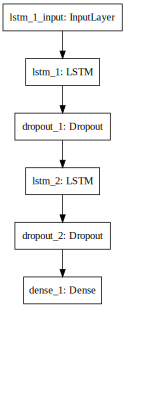

In [11]:
# LSTMモデルをプロット、保存
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='model_v4a.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

# 予測　バリデーションデータ

In [12]:
# 予測
est_scaled = model.predict(x_cv_scaled)
est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
print("est.shape = " + str(est.shape))

# RMSErrorを求める
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, est))
print("RMSE = %0.3f" % rmse_bef_tuning)

# MAPErrorを求める
mape_pct_bef_tuning = get_mape(y_cv, est)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

est.shape = (239, 1)
RMSE = 23.963
MAPE = 0.962%


Text(0, 0.5, 'JPY')

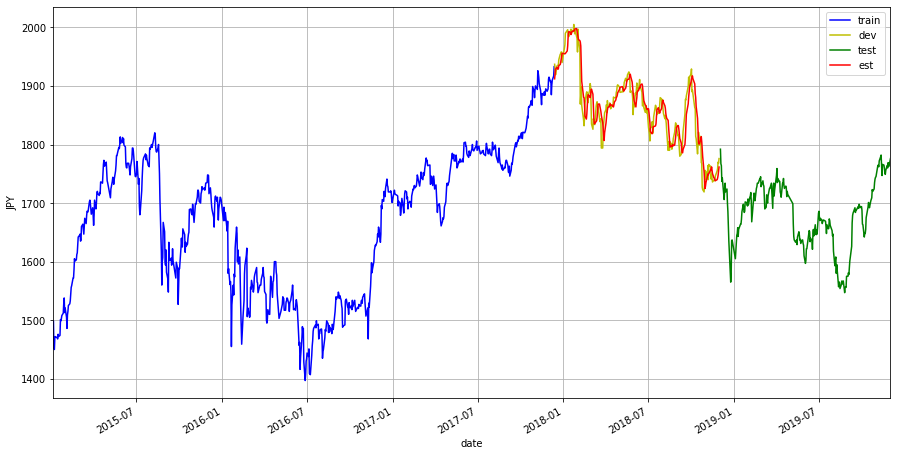

In [13]:
# trading_valueをプロット
rcParams['figure.figsize'] = 15, 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'y_cv': y_cv.reshape(-1),
                       'date': cv['date']})

ax = train.plot(x='date', y='trading_value', style='b-', grid=True)
ax = cv.plot(x='date', y='trading_value', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='trading_value', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("JPY")

# モデルチューニング：N（特徴量として使用する直前の日数）

In [14]:
param_label = 'N'
param_list = range(4, 60)

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in notebook.tqdm(param_list):
    
    # x,yに分割
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)

    # cvをx,yに分割
    x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['trading_value']).reshape(-1,1), param, num_train)
    
    # モデルを訓練、予測、評価
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv, \
                                          mu_cv_list, \
                                          std_cv_list, \
                                          lstm_units=lstm_units, \
                                          dropout_prob=dropout_prob, \
                                          optimizer=optimizer, \
                                          epochs=epochs, \
                                          batch_size=batch_size)

    # 結果
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate


Minutes taken = 29.94366726477941


,N,rmse,mape_pct
0,4,23.082424,0.928887
1,5,24.997628,1.019425
2,6,24.617802,0.994199
3,7,25.657896,1.039034
4,8,24.956679,1.009304
5,9,25.825477,1.052592
6,10,24.284113,0.977929
7,11,25.754816,1.038796
8,12,23.610573,0.953817
9,13,24.259588,0.998090


Text(0, 0.5, 'RMSE/MAPE(%)')

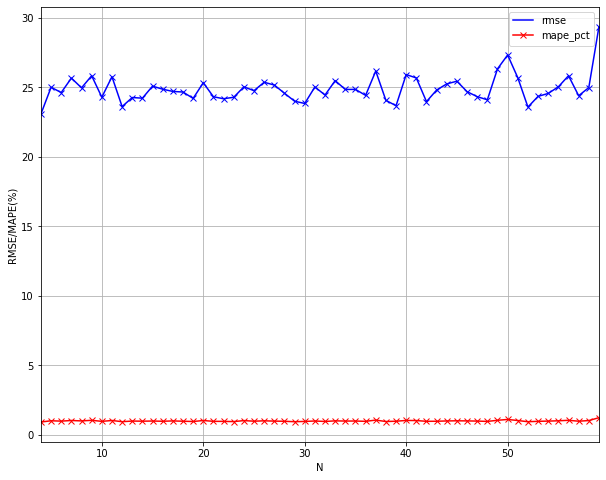

In [15]:
# RMSErrorをプロット
rcParams['figure.figsize'] = 10, 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

In [16]:
# 最適なパラメータを取得
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 23.082
min MAPE = 0.929%
optimum N = 4


# モデルチューニング ：epoch, batch_size

In [17]:
param_label = 'epochs'
param_list = [1, 10, 20, 30, 40, 50]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]

# trainをx,yに分割
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)

# cvをx,yに分割
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['trading_value']).reshape(-1,1), N_opt, num_train)

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in notebook.tqdm(param_list):
    
    for param2 in notebook.tqdm(param2_list):
    
        # 訓練、予測、評価
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv, \
                                              mu_cv_list, \
                                              std_cv_list, \
                                              lstm_units=lstm_units, \
                                              dropout_prob=dropout_prob, \
                                              optimizer=optimizer, \
                                              epochs=param, \
                                              batch_size=param2)
    
        # 結果
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()

In [18]:
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

Minutes taken = 18.52909203370412


,epochs,batch_size,rmse,mape_pct
0,1,8,24.685992,0.994671
1,1,16,25.463882,1.023144
2,1,32,23.369055,0.939989
3,1,64,22.039579,0.887917
4,1,128,21.866896,0.878830
5,10,8,19.367973,0.767561
6,10,16,22.661771,0.909656
7,10,32,23.796132,0.955700
8,10,64,24.520476,0.988004
9,10,128,24.814276,1.001915


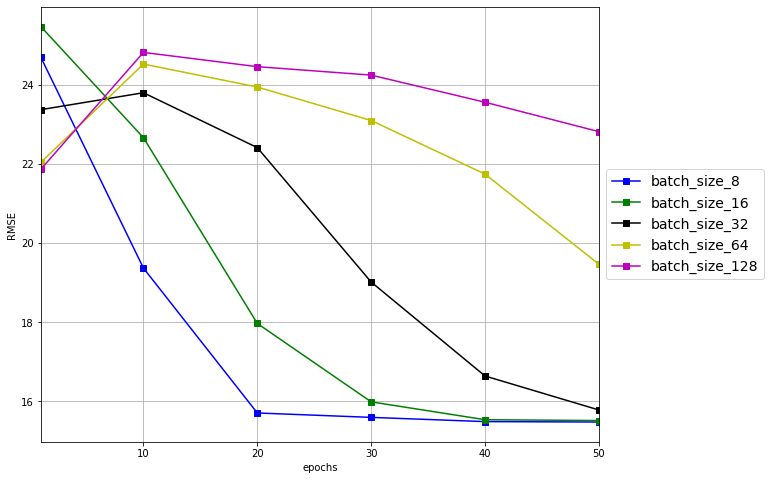

In [19]:
# 各パラメータに対する性能をプロット
rcParams['figure.figsize'] = 10, 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5))

In [20]:
# 最適なパラメータを決定
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

min RMSE = 15.481
min MAPE = 0.600%
optimum epochs = 50
optimum batch_size = 8


# モデルチューニング：LSTM unit, dropout prob

In [21]:
param_label = 'lstm_units'
param_list = [10, 50, 64, 128]

param2_label = 'dropout_prob'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in notebook.tqdm(param_list):
    
    for param2 in notebook.tqdm(param2_list):
    
        # モデルを訓練、予測、評価
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv, \
                                              mu_cv_list, \
                                              std_cv_list, \
                                              lstm_units=param, \
                                              dropout_prob=param2, \
                                              optimizer=optimizer, \
                                              epochs=epochs_opt, \
                                              batch_size=batch_size_opt)
    
        # 結果
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate



Minutes taken = 75.91927573283513


,lstm_units,dropout_prob,rmse,mape_pct
0,10,0.5,21.655677,0.868709
1,10,0.6,21.965069,0.884790
2,10,0.7,22.168114,0.893696
3,10,0.8,23.572945,0.949218
4,10,0.9,23.642310,0.955579
5,10,1.0,15.934340,0.626331
6,50,0.5,16.217936,0.639524
7,50,0.6,16.979035,0.670914
8,50,0.7,18.393599,0.730144
9,50,0.8,20.615147,0.830339


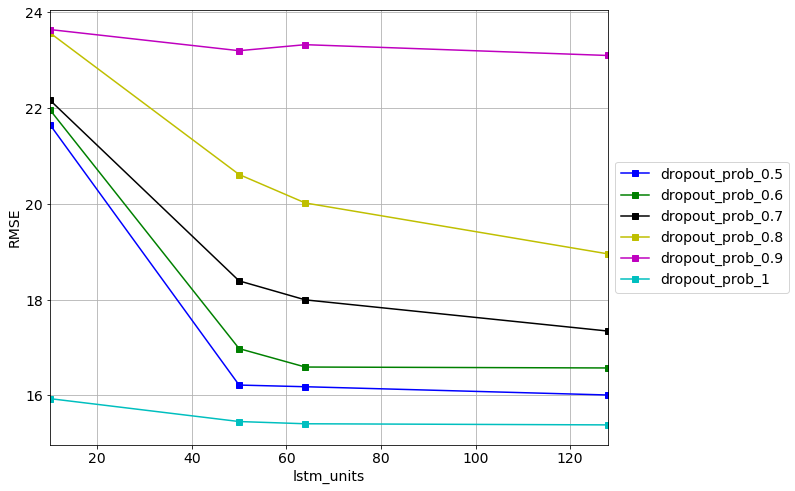

In [22]:
# 各パラメータに対する性能をプロット
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5))

In [23]:
# 最適なパラメータを決定
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param2_label + " = " + str(dropout_prob_opt))

min RMSE = 15.386
min MAPE = 0.597%
optimum lstm_units = 128
optimum dropout_prob = 1.0


# モデルチューニング： optimizer

In [24]:
param_label = 'optimizer'
param_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in notebook.tqdm(param_list):
   
    # モデルの訓練、予測、評価
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv, \
                                          mu_cv_list, \
                                          std_cv_list, \
                                          lstm_units=lstm_units_opt, \
                                          dropout_prob=dropout_prob_opt, \
                                          optimizer=param, \
                                          epochs=epochs_opt, \
                                          batch_size=batch_size_opt)
    
    # 結果
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate


Minutes taken = 15.029093384742737


,optimizer,rmse,mape_pct
0,adam,15.377259,0.596120
1,sgd,22.977583,0.923183
2,rmsprop,15.542206,0.604052
3,adagrad,15.531462,0.600592
4,adadelta,15.341741,0.593193
5,adamax,15.412239,0.596065
6,nadam,15.392355,0.600904


Text(0, 0.5, 'RMSE/MAPE(%)')

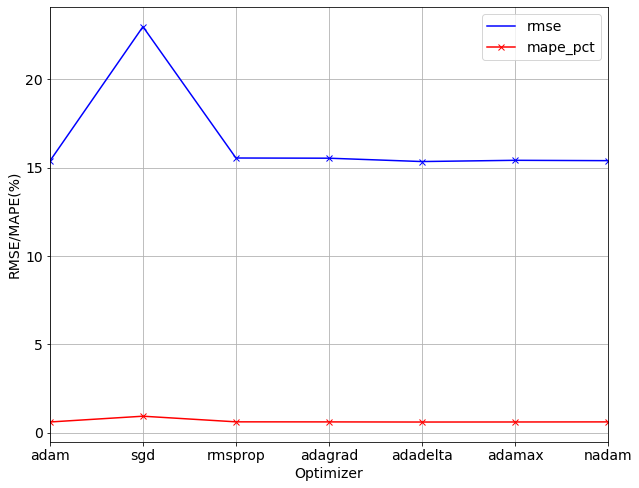

In [25]:
# RMSErrorをプロット
rcParams['figure.figsize'] = 10, 8

ax = error_rate.plot(x='optimizer', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='optimizer', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xticklabels(param_list)
ax.set_xlabel("Optimizer")
ax.set_ylabel("RMSE/MAPE(%)")

In [26]:
# 最適なパラメータを決定
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimizer_opt = temp[param_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(optimizer_opt))

min RMSE = 15.342
min MAPE = 0.593%
optimum optimizer = adadelta


# チューニング後のパラメータ

In [27]:
d = {'param': ['N', 'lstm_units', 'dropout_prob', 'optimizer', 'epochs', 'batch_size', 'rmse', 'mape_pct'],
     'original': [N, lstm_units, dropout_prob, optimizer, epochs, batch_size, rmse_bef_tuning, mape_pct_bef_tuning],
     'after_tuning': [N_opt, lstm_units_opt, dropout_prob_opt, optimizer_opt, epochs_opt, batch_size_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params

,param,original,after_tuning
0,N,4,4
1,lstm_units,50,128
2,dropout_prob,1,1
3,optimizer,adam,adadelta
4,epochs,1,50
5,batch_size,1,8
6,rmse,23.9635,15.3417
7,mape_pct,0.962184,0.593193


# 最終モデル

In [32]:
# train_cvをx,yに分割
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, N_opt, N_opt)

# testをx,yに分割
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['trading_value']).reshape(-1,1), N_opt, num_train+num_cv)

#  訓練、予測、評価
rmse, mape, est = train_pred_eval_model(x_train_cv_scaled, \
                                        y_train_cv_scaled, \
                                        x_test_scaled, \
                                        y_test, \
                                        mu_test_list, \
                                        std_test_list, \
                                        lstm_units=lstm_units_opt, \
                                        dropout_prob=dropout_prob_opt, \
                                        optimizer=optimizer_opt, \
                                        epochs=epochs_opt, \
                                        batch_size=batch_size_opt)

# RMSE
print("RMSE on test set = %0.3f" % rmse)

# MAPE 
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 14.734
MAPE on test set = 0.634%


Text(0, 0.5, 'JPY')

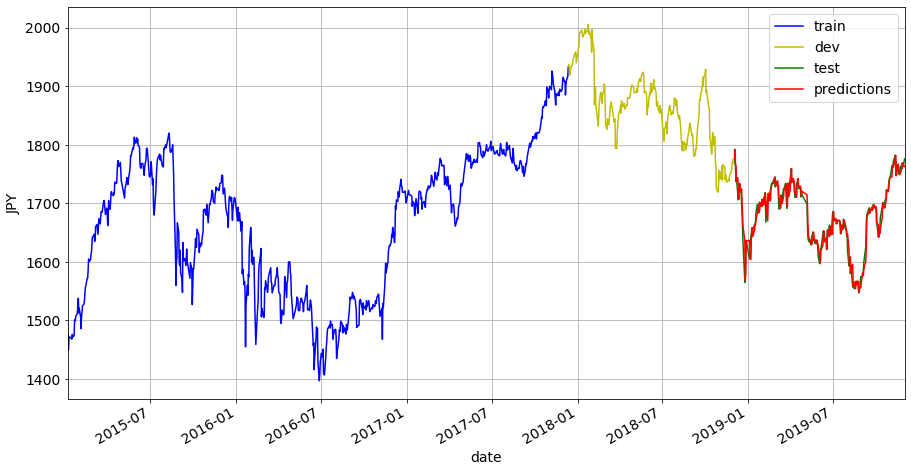

In [40]:
# trading_valueをプロット
rcParams['figure.figsize'] = 15, 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[num_train+num_cv:]['date']})

ax = train.plot(x='date', y='trading_value', style='b-', grid=True)
ax = cv.plot(x='date', y='trading_value', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='trading_value', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("JPY")

(737038.0, 737395.0)

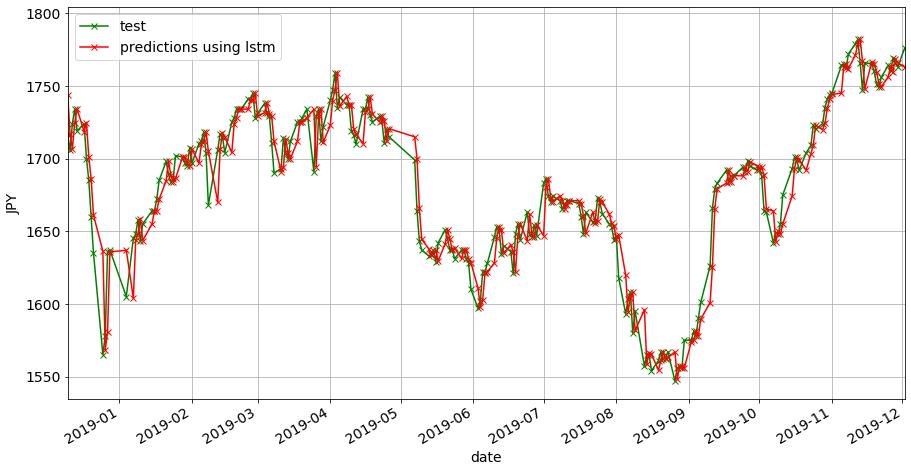

In [42]:
# trading_value(test)をプロット
rcParams['figure.figsize'] = 15, 8

ax = test.plot(x='date', y='trading_value', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using lstm'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("JPY")
ax.set_xlim([date(2018, 12, 10), date(2019, 12, 2)])

In [35]:
# 保存
test_lstm = est_df
test_lstm.to_csv("./out/test_lstm.csv")